# Session 3: Unsupervised and Supervised Learning

<p class="lead">
Assignment: Build Unsupervised and Supervised Networks
</p>

<p class="lead">
Parag K. Mital<br />
<a href="https://www.kadenze.com/courses/creative-applications-of-deep-learning-with-tensorflow/info">Creative Applications of Deep Learning w/ Tensorflow</a><br />
<a href="https://www.kadenze.com/partners/kadenze-academy">Kadenze Academy</a><br />
<a href="https://twitter.com/hashtag/CADL">#CADL</a>
</p>

<a name="learning-goals"></a>
# Learning Goals

* Learn how to build an autoencoder
* Learn how to explore latent/hidden representations of an autoencoder.
* Learn how to build a classification network using softmax and onehot encoding

# Outline

<!-- MarkdownTOC autolink=true autoanchor=true bracket=round -->

- [Assignment Synopsis](#assignment-synopsis)
- [Part One - Autoencoders](#part-one---autoencoders)
    - [Instructions](#instructions)
    - [Code](#code)
    - [Visualize the Embedding](#visualize-the-embedding)
    - [Reorganize to Grid](#reorganize-to-grid)
    - [2D Latent Manifold](#2d-latent-manifold)
- [Part Two - General Autoencoder Framework](#part-two---general-autoencoder-framework)
    - [Instructions](#instructions-1)
- [Part Three - Deep Audio Classification Network](#part-three---deep-audio-classification-network)
    - [Instructions](#instructions-2)
    - [Preparing the Data](#preparing-the-data)
    - [Creating the Network](#creating-the-network)
- [Assignment Submission](#assignment-submission)
- [Coming Up](#coming-up)

<!-- /MarkdownTOC -->

This next section will just make sure you have the right version of python and the libraries that we'll be using.  Don't change the code here but make sure you "run" it (use "shift+enter")!

In [1]:
# First check the Python version
import sys
if sys.version_info < (3,4):
    print('You are running an older version of Python!\n\n' \
          'You should consider updating to Python 3.4.0 or ' \
          'higher as the libraries built for this course ' \
          'have only been tested in Python 3.4 and higher.\n')
    print('Try installing the Python 3.5 version of anaconda '
          'and then restart `jupyter notebook`:\n' \
          'https://www.continuum.io/downloads\n\n')

# Now get necessary libraries
try:
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from skimage.transform import resize
    from skimage import data
    from scipy.misc import imresize
    import IPython.display as ipyd
except ImportError:
    print('You are missing some packages! ' \
          'We will try installing them before continuing!')
    !pip install "numpy>=1.11.0" "matplotlib>=1.5.1" "scikit-image>=0.11.3" "scikit-learn>=0.17" "scipy>=0.17.0"
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from skimage.transform import resize
    from skimage import data
    from scipy.misc import imresize
    import IPython.display as ipyd
    print('Done!')

# Import Tensorflow
try:
    import tensorflow as tf
except ImportError:
    print("You do not have tensorflow installed!")
    print("Follow the instructions on the following link")
    print("to install tensorflow before continuing:")
    print("")
    print("https://github.com/pkmital/CADL#installation-preliminaries")

# This cell includes the provided libraries from the zip file
# and a library for displaying images from ipython, which
# we will use to display the gif
try:
    from libs import utils, gif, datasets, dataset_utils, vae, dft
except ImportError:
    print("Make sure you have started notebook in the same directory" +
          " as the provided zip file which includes the 'libs' folder" +
          " and the file 'utils.py' inside of it.  You will NOT be able"
          " to complete this assignment unless you restart jupyter"
          " notebook inside the directory created by extracting"
          " the zip file or cloning the github repo.")

# We'll tell matplotlib to inline any drawn figures like so:
%matplotlib inline
plt.style.use('ggplot')

In [2]:
# Bit of formatting because I don't like the default inline code style:
from IPython.core.display import HTML
HTML("""<style> .rendered_html code { 
    padding: 2px 4px;
    color: #c7254e;
    background-color: #f9f2f4;
    border-radius: 4px;
} </style>""")

<a name="assignment-synopsis"></a>
# Assignment Synopsis

In the last session we created our first neural network.  We saw that in order to create a neural network, we needed to define a cost function which would allow gradient descent to optimize all the parameters in our network.  We also saw how neural networks become much more expressive by introducing series of linearities followed by non-linearities, or activation functions.  We then explored a fun application of neural networks using regression to learn to paint color values given x, y positions.  This allowed us to build up a sort of painterly like version of an image.

In this session, we'll see how to construct a few more types of neural networks.  First, we'll explore a generative network called autoencoders.  This network can be extended in a variety of ways to include convolution, denoising, or a variational layer.  In Part Two, you'll then use a general autoencoder framework to encode your own list of images.  In Part three, we'll then explore a discriminative network used for classification, and see how this can be used for audio classification of music or speech.

One main difference between these two networks are the data that we'll use to train them.  In the first case, we will only work with "unlabeled" data and perform unsupervised learning.  An example would be a collection of images, just like the one you created for assignment 1.  Contrast this with "labeled" data which allows us to make use of supervised learning.  For instance, we're given both images, and some other data about those images such as some text describing what object is in the image.  This allows us to optimize a network where we model a distribution over the images given that it should be labeled as something.  This is often a *much* simpler distribution to train, but with the expense of it being much harder to collect.

One of the major directions of future research will be in how to better make use of unlabeled data and unsupervised learning methods.

<a name="part-one---autoencoders"></a>
# Part One - Autoencoders

<a name="instructions"></a>
## Instructions

Work with a dataset of images and train an autoencoder.  You can work with the same dataset from assignment 1, or try a larger dataset.  But be careful with the image sizes, and make sure to keep it relatively small (e.g. < 100 x 100 px).  

Recall from the lecture that autoencoders are great at "compressing" information.  The network's construction and cost function are just like what we've done in the last session.  The network is composed of a series of matrix multiplications and nonlinearities.  The only difference is the output of the network has exactly the same shape as what is input.  This allows us to train the network by saying that the output of the network needs to be just like the input to it, so that it tries to "compress" all the information in that video.

Autoencoders have some great potential for creative applications, as they allow us to compress a dataset of information and even *generate* new data from that encoding.  We'll see exactly how to do this with a basic autoencoder, and then you'll be asked to explore some of the extensions to produce your own encodings.

<a name="code"></a>
## Code

We'll now go through the process of building an autoencoder just like in the lecture.  First, let's load some data.  You can use the first 100 images of the Celeb Net, your own dataset, or anything else approximately under 1,000 images.  Make sure you resize the images so that they are <= 100x100 pixels, otherwise the training will be *very* slow, and the montages we create will be too large.

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [3]:
# See how this works w/ Celeb Images or try your own dataset instead:
dirname = '../data/pokemon/jpeg/'

# Load every image file in the provided directory
filenames = [os.path.join(dirname, fname)
             for fname in os.listdir(dirname)]
imgs = [plt.imread(fname)[..., :3] for fname in filenames]

# Shuffle and limit the number of files to process
nb_clip = 800
imgs = np.array(imgs)
# np.random.shuffle(imgs)
imgs = imgs[:nb_clip]

# Then convert the list of images to a 4d array (e.g. use np.array to convert a list to a 4d array):
Xs = imgs.reshape(-1, 64, 64, 3 )

print(Xs.shape)
assert(Xs.ndim == 4 and Xs.shape[1] <= 100 and Xs.shape[2] <= 100)

(800, 64, 64, 3)


We'll now make use of something I've written to help us store this data.  It provides some interfaces for generating "batches" of data, as well as splitting the data into training, validation, and testing sets.  To use it, we pass in the data and optionally its labels.  If we don't have labels, we just pass in the data.  In the second half of this notebook, we'll explore using a dataset's labels as well.

In [4]:
ds = datasets.Dataset(Xs)
# ds = datasets.CIFAR10(flatten=False)

It allows us to easily find the mean:

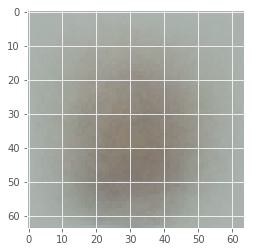

In [5]:
mean_img = ds.mean().astype(np.uint8)
plt.imshow(mean_img)
# If your image comes out entirely black, try w/o the `astype(np.uint8)`
# that means your images are read in as 0-255, rather than 0-1 and 
# this simply depends on the version of matplotlib you are using.

Or the deviation:

(64, 64, 3)


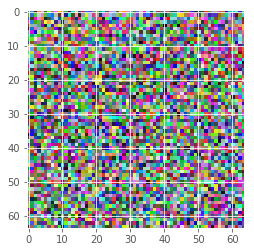

In [6]:
std_img = ds.std()
plt.imshow(std_img)
print(std_img.shape)

Recall we can calculate the mean of the standard deviation across each color channel:

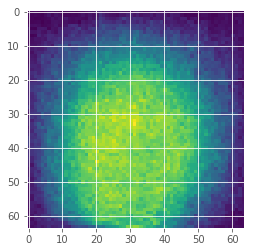

In [7]:
std_img = np.mean(std_img, axis=2)
plt.imshow(std_img)

All the input data we gave as input to our `Datasets` object, previously stored in `Xs` is now stored in a variable as part of our `ds` Datasets object, `X`:

(800, 64, 64, 3)


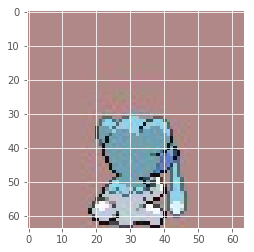

In [8]:
plt.imshow(ds.X[0])
print(ds.X.shape)

It takes a parameter, `split` at the time of creation, which allows us to create train/valid/test sets.  By default, this is set to `[1.0, 0.0, 0.0]`, which means to take all the data in the train set, and nothing in the validation and testing sets.  We can access "batch generators" of each of these sets by saying: `ds.train.next_batch`.  A generator is a really powerful way of handling iteration in Python.  If you are unfamiliar with the idea of generators, I recommend reading up a little bit on it, e.g. here: http://intermediatepythonista.com/python-generators - think of it as a for loop, but as a function.  It returns one iteration of the loop each time you call it.

This generator will automatically handle the randomization of the dataset.  Let's try looping over the dataset using the batch generator:

In [9]:
for (X, y) in ds.train.next_batch(batch_size=10):
    print(X.shape)

(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64, 64, 3)
(10, 64,

This returns `X` and `y` as a tuple.  Since we're not using labels, we'll just ignore this.  The `next_batch` method takes a parameter, `batch_size`, which we'll set appropriately to our batch size.  Notice it runs for exactly 10 iterations to iterate over our 100 examples, then the loop exits.  The order in which it iterates over the 100 examples is randomized each time you iterate.

Write two functions to preprocess (normalize) any given image, and to unprocess it, i.e. unnormalize it by removing the normalization.  The `preprocess` function should perform exactly the task you learned to do in assignment 1: subtract the mean, then divide by the standard deviation.  The `deprocess` function should take the preprocessed image and undo the preprocessing steps.  Recall that the `ds` object contains the `mean` and `std` functions for access the mean and standarad deviation.  We'll be using the `preprocess` and `deprocess` functions on the input and outputs of the network.  Note, we could use Tensorflow to do this instead of numpy, but for sake of clarity, I'm keeping this separate from the Tensorflow graph.

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [10]:
# Write a function to preprocess/normalize an image, given its dataset object
# (which stores the mean and standard deviation!)
def preprocess(img, ds):
    norm_img = (img - ds.mean()) / ds.std()
    return norm_img

# Write a function to undo the normalization of an image, given its dataset object
# (which stores the mean and standard deviation!)
def deprocess(norm_img, ds):
    img = norm_img * ds.std() + ds.mean()
    return img

We're going to now work on creating an autoencoder.  To start, we'll only use linear connections, like in the last assignment.  This means, we need a 2-dimensional input:  Batch Size x Number of Features.  We currently have a 4-dimensional input: Batch Size x Height x Width x Channels.  We'll have to calculate the number of features we have to help construct the Tensorflow Graph for our autoencoder neural network.  Then, when we are ready to train the network, we'll reshape our 4-dimensional dataset into a 2-dimensional one when feeding the input of the network.  Optionally, we could create a `tf.reshape` as the first operation of the network, so that we can still pass in our 4-dimensional array, and the Tensorflow graph would reshape it for us.  We'll try the former method, by reshaping manually, and then you can explore the latter method, of handling 4-dimensional inputs on your own.

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [11]:
# Calculate the number of features in your image.
# This is the total number of pixels, or (height x width x channels).
nb_features = len(ds.X[0].flatten())
print(nb_features)

12288


In [12]:
64*64*3

12288

Let's create a list of how many neurons we want in each layer.  This should be for just one half of the network, the encoder only.  It should start large, then get smaller and smaller.  We're also going to try an encode our dataset to an inner layer of just 2 values.  So from our number of features, we'll go all the way down to expressing that image by just 2 values.  Try a small network to begin with, then explore deeper networks:

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [13]:
encoder_dimensions = [128, 64, 32, 16, 8, 4, 2]

Now create a placeholder just like in the last session in the tensorflow graph that will be able to get any number (None) of `n_features` inputs.

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [21]:
tf.reset_default_graph()

In [22]:
X = tf.placeholder(np.float32, [None, nb_features])
                   
assert(X.get_shape().as_list() == [None, nb_features])

Now complete the function `encode` below.  This takes as input our input placeholder, `X`, our list of `dimensions`, and an `activation` function, e.g. `tf.nn.relu` or `tf.nn.tanh`, to apply to each layer's output, and creates a series of fully connected layers.  This works just like in the last session!  We multiply our input, add a bias, then apply a non-linearity.  Instead of having 20 neurons in each layer, we're going to use our `dimensions` list to tell us how many neurons we want in each layer.

One important difference is that we're going to also store every weight matrix we create!  This is so that we can use the same weight matrices when we go to build our decoder.  This is a *very* powerful concept that creeps up in a few different neural network architectures called weight sharing.  Weight sharing isn't necessary to do of course, but can speed up training and offer a different set of features depending on your dataset.  Explore trying both.  We'll also see how another form of weight sharing works in convolutional networks.

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [23]:
def encode(X, dimensions, activation=tf.nn.tanh):
    # We're going to keep every matrix we create so let's create a list to hold them all
    Ws = []

    # We'll create a for loop to create each layer:
    for layer_i, nb_output in enumerate(dimensions):

        # TODO: just like in the last session,
        # we'll use a variable scope to help encapsulate our variables
        # This will simply prefix all the variables made in this scope
        # with the name we give it.  Make sure it is a unique name
        # for each layer, e.g., 'encoder/layer1', 'encoder/layer2', or
        # 'encoder/1', 'encoder/2',... 
        with tf.variable_scope('encode/layer/{}'.format(layer_i)):

            # TODO: Create a weight matrix which will increasingly reduce
            # down the amount of information in the input by performing
            # a matrix multiplication.  You can use the utils.linear function.
            h, W = utils.linear(X, nb_output, activation=tf.nn.relu)
            
            # TODO: Apply an activation function (unless you used the parameter
            # for activation function in the utils.linear call)

            # Finally we'll store the weight matrix.
            # We need to keep track of all
            # the weight matrices we've used in our encoder
            # so that we can build the decoder using the
            # same weight matrices.
            Ws.append(W)
            
            # Replace X with the current layer's output, so we can
            # use it in the next layer.
            X = h
    
    z = X
    return Ws, z

We now have a function for encoding an input `X`.  Take note of which activation function you use as this will be important for the behavior of the latent encoding, `z`, later on.

In [24]:
# Then call the function
Ws, z = encode(X, encoder_dimensions)

# And just some checks to make sure you've done it right.
assert(z.get_shape().as_list() == [None, 2])
assert(len(Ws) == len(encoder_dimensions))

Let's take a look at the graph:

In [25]:
[op.name for op in tf.get_default_graph().get_operations()]

['Placeholder',
 'encode/layer/0/fc/W/Initializer/random_uniform/shape',
 'encode/layer/0/fc/W/Initializer/random_uniform/min',
 'encode/layer/0/fc/W/Initializer/random_uniform/max',
 'encode/layer/0/fc/W/Initializer/random_uniform/RandomUniform',
 'encode/layer/0/fc/W/Initializer/random_uniform/sub',
 'encode/layer/0/fc/W/Initializer/random_uniform/mul',
 'encode/layer/0/fc/W/Initializer/random_uniform',
 'encode/layer/0/fc/W',
 'encode/layer/0/fc/W/Assign',
 'encode/layer/0/fc/W/read',
 'encode/layer/0/fc/b/Initializer/Const',
 'encode/layer/0/fc/b',
 'encode/layer/0/fc/b/Assign',
 'encode/layer/0/fc/b/read',
 'encode/layer/0/fc/MatMul',
 'encode/layer/0/fc/h',
 'encode/layer/0/fc/Relu',
 'encode/layer/1/fc/W/Initializer/random_uniform/shape',
 'encode/layer/1/fc/W/Initializer/random_uniform/min',
 'encode/layer/1/fc/W/Initializer/random_uniform/max',
 'encode/layer/1/fc/W/Initializer/random_uniform/RandomUniform',
 'encode/layer/1/fc/W/Initializer/random_uniform/sub',
 'encode/layer

So we've created a few layers, encoding our input `X` all the way down to 2 values in the tensor `z`.  We do this by multiplying our input `X` by a set of matrices shaped as:

In [26]:
[W_i.get_shape().as_list() for W_i in Ws]

[[12288, 128], [128, 64], [64, 32], [32, 16], [16, 8], [8, 4], [4, 2]]

Resulting in a layer which is shaped as:

In [27]:
z.get_shape().as_list()

[None, 2]

## Building the Decoder 

Here is a helpful animation on what the matrix "transpose" operation does:
![transpose](https://upload.wikimedia.org/wikipedia/commons/e/e4/Matrix_transpose.gif)

Basically what is happening is rows becomes columns, and vice-versa.  We're going to use our existing weight matrices but transpose them so that we can go in the opposite direction.  In order to build our decoder, we'll have to do the opposite of what we've just done, multiplying `z` by the transpose of our weight matrices, to get back to a reconstructed version of `X`.  First, we'll reverse the order of our weight matrics, and then append to the list of dimensions the final output layer's shape to match our input:

In [29]:
# We'll first reverse the order of our weight matrices
decoder_Ws = Ws[::-1]

# then reverse the order of our dimensions
# appending the last layers number of inputs.
decoder_dimensions = encoder_dimensions[::-1][1:] + [nb_features]
print(decoder_dimensions)

assert(decoder_dimensions[-1] == nb_features)

[4, 8, 16, 32, 64, 128, 12288]


Now we'll build the decoder.  I've shown you how to do this.  Read through the code to fully understand what it is doing:

In [30]:
def decode(z, dimensions, Ws, activation=tf.nn.tanh):
    current_input = z
    for layer_i, n_output in enumerate(dimensions):
        # we'll use a variable scope again to help encapsulate our variables
        # This will simply prefix all the variables made in this scope
        # with the name we give it.
        with tf.variable_scope("decoder/layer/{}".format(layer_i)):

            # Now we'll grab the weight matrix we created before and transpose it
            # So a 3072 x 784 matrix would become 784 x 3072
            # or a 256 x 64 matrix, would become 64 x 256
            W = tf.transpose(Ws[layer_i])

            # Now we'll multiply our input by our transposed W matrix
            h = tf.matmul(current_input, W)

            # And then use a relu activation function on its output
            current_input = activation(h)

            # We'll also replace n_input with the current n_output, so that on the
            # next iteration, our new number inputs will be correct.
            n_input = n_output
    Y = current_input
    return Y

In [31]:
Y = decode(z, decoder_dimensions, decoder_Ws)

Let's take a look at the new operations we've just added.  They will all be prefixed by "decoder" so we can use list comprehension to help us with this:

In [32]:
[op.name for op in tf.get_default_graph().get_operations()
 if op.name.startswith('decoder')]

['decoder/layer/0/transpose/Rank',
 'decoder/layer/0/transpose/sub/y',
 'decoder/layer/0/transpose/sub',
 'decoder/layer/0/transpose/Range/start',
 'decoder/layer/0/transpose/Range/delta',
 'decoder/layer/0/transpose/Range',
 'decoder/layer/0/transpose/sub_1',
 'decoder/layer/0/transpose',
 'decoder/layer/0/MatMul',
 'decoder/layer/0/Tanh',
 'decoder/layer/1/transpose/Rank',
 'decoder/layer/1/transpose/sub/y',
 'decoder/layer/1/transpose/sub',
 'decoder/layer/1/transpose/Range/start',
 'decoder/layer/1/transpose/Range/delta',
 'decoder/layer/1/transpose/Range',
 'decoder/layer/1/transpose/sub_1',
 'decoder/layer/1/transpose',
 'decoder/layer/1/MatMul',
 'decoder/layer/1/Tanh',
 'decoder/layer/2/transpose/Rank',
 'decoder/layer/2/transpose/sub/y',
 'decoder/layer/2/transpose/sub',
 'decoder/layer/2/transpose/Range/start',
 'decoder/layer/2/transpose/Range/delta',
 'decoder/layer/2/transpose/Range',
 'decoder/layer/2/transpose/sub_1',
 'decoder/layer/2/transpose',
 'decoder/layer/2/MatMu

And let's take a look at the output of the autoencoder:

In [33]:
Y.get_shape().as_list()

[None, 12288]

Great!  So we should have a synthesized version of our input placeholder, `X`, inside of `Y`.  This `Y` is the result of many matrix multiplications, first a series of multiplications in our encoder all the way down to 2 dimensions, and then back to the original dimensions through our decoder.  Let's now create a pixel-to-pixel measure of error.  This should measure the difference in our synthesized output, `Y`, and our input, `X`.  You can use the $l_1$ or $l_2$ norm, just like in assignment 2.  If you don't remember, go back to homework 2 where we calculated the cost function and try the same idea here.

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [45]:
# Calculate some measure of loss, e.g. the pixel to pixel absolute difference or squared difference
loss = tf.reduce_mean(tf.squared_difference(X, Y), 1)

# Now sum over every pixel and then calculate the mean over the batch dimension (just like session 2!)
# hint, use tf.reduce_mean and tf.reduce_sum
cost = tf.reduce_mean(loss)

Now for the standard training code.  We'll pass our `cost` to an optimizer, and then use mini batch gradient descent to optimize our network's parameters.  We just have to be careful to make sure we're preprocessing our input and feed it in the right shape, a 2-dimensional matrix of [batch_size, n_features] in dimensions.

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [35]:
learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

Below is the training code for our autoencoder.  Please go through each line of code to make sure you understand what is happening, and fill in the missing pieces.  This will take awhile.  On my machine, it takes about 15 minutes.  If you're impatient, you can "Interrupt" the kernel by going to the Kernel menu above, and continue with the notebook.  Though, the longer you leave this to train, the better the result will be.

What I really want you to notice is what the network learns to encode first, based on what it is able to reconstruct.  It won't able to reconstruct everything.  At first, it will just be the mean image.  Then, other major changes in the dataset.  For the first 100 images of celeb net, this seems to be the background: white, blue, black backgrounds.  From this basic interpretation, you can reason that the autoencoder has learned a representation of the backgrounds, and is able to encode that knowledge of the background in its inner most layer of just two values.  It then goes on to represent the major variations in skin tone and hair.  Then perhaps some facial features such as lips.  So the features it is able to encode tend to be the major things at first, then the smaller things.

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [36]:
# (TODO) Create a tensorflow session and initialize all of our weights:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

Note that if you run into "InternalError" or "ResourceExhaustedError", it is likely that you have run out of memory!  Try a smaller network!  For instance, restart the notebook's kernel, and then go back to defining `encoder_dimensions = [256, 2]` instead.  If you run into memory problems below, you can also try changing the batch_size to 50.

## Tensorboard

In [37]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [38]:
show_graph(tf.get_default_graph().as_graph_def())

0 7.8309687227e-05


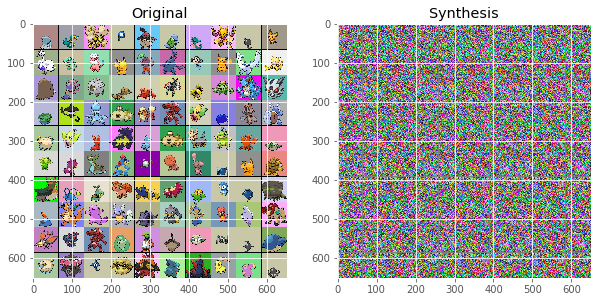

1 7.82852113247e-05
2 7.82325930893e-05
3 7.81572416425e-05
4 7.80910924077e-05
5 7.80522681773e-05
6 7.8021299839e-05
7 7.80066668987e-05
8 7.80140168965e-05
9 7.7990642935e-05
10 7.79613859951e-05


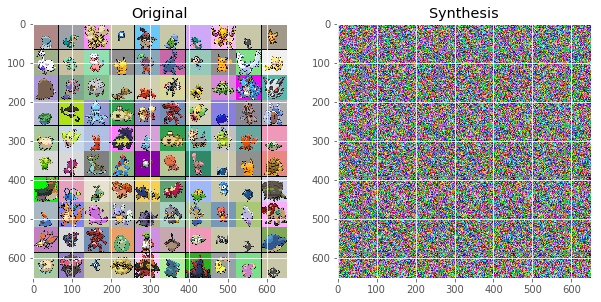

11 7.79022783041e-05
12 7.78477244079e-05
13 7.78109051287e-05
14 7.77852021158e-05
15 7.7748901397e-05
16 7.77726985514e-05
17 7.78344094753e-05
18 7.78255656362e-05
19 7.78917036951e-05
20 7.76558279991e-05


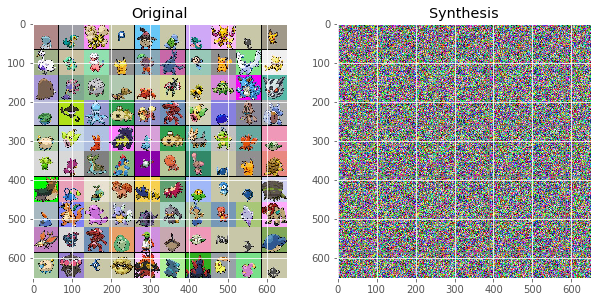

21 7.76896566153e-05
22 7.77383647859e-05
23 7.76623547077e-05
24 8.01145605743e-05
25 8.11114065349e-05
26 8.10949772596e-05
27 8.05505700409e-05
28 7.92803823948e-05
29 7.88445517421e-05
30 7.85204797983e-05


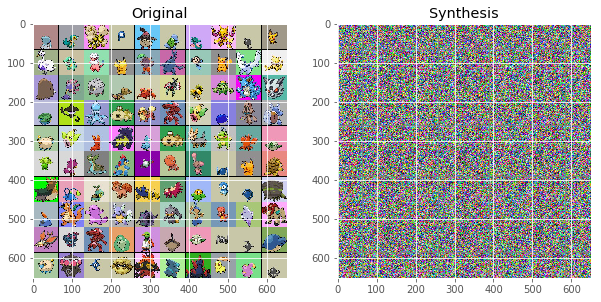

In [46]:
# Some parameters for training
batch_size = 100
nb_epochs = 31
step = 10

# We'll try to reconstruct the same first 100 images and show how
# The network does over the course of training.
examples = ds.X[:100]

# We have to preprocess the images before feeding them to the network.
# I'll do this once here, so we don't have to do it every iteration.
test_examples = preprocess(examples, ds).reshape(-1, nb_features)

# If we want to just visualize them, we can create a montage.
test_images = utils.montage(examples).astype(np.uint8)

# Store images so we can make a gif
gifs = []

# Now for our training:
for epoch_i in range(nb_epochs):
    
    # Keep track of the cost
    this_cost = 0
    
    # Iterate over the entire dataset in batches
    for batch_X, _ in ds.train.next_batch(batch_size=batch_size):
        
        # (TODO) Preprocess and reshape our current batch, batch_X:
        this_batch = preprocess(batch_X, ds).reshape(-1, nb_features)
        
        # Compute the cost, and run the optimizer.
        this_cost += sess.run([cost, optimizer], feed_dict={X: this_batch})[0]
    
    # Average cost of this epoch
    avg_cost = this_cost / ds.X.shape[0] / batch_size
    print(epoch_i, avg_cost)
    
    # Let's also try to see how the network currently reconstructs the input.
    # We'll draw the reconstruction every `step` iterations.
    if epoch_i % step == 0:
        
        # (TODO) Ask for the output of the network, Y, and give it our test examples
        recon = sess.run(Y, feed_dict={X: batch_X.reshape(-1, nb_features)})
                         
        # Resize the 2d to the 4d representation:
        rsz = recon.reshape(examples.shape)

        # We have to unprocess the image now, removing the normalization
        unnorm_img = deprocess(rsz, ds)
                         
        # Clip to avoid saturation
        # TODO: Make sure this image is the correct range, e.g.
        # for float32 0-1, you should clip between 0 and 1
        # for uint8 0-255, you should clip between 0 and 255!
        clipped = np.clip(unnorm_img, 0, 255)

        # And we can create a montage of the reconstruction
        recon = utils.montage(clipped)
        
        # Store for gif
        gifs.append(recon)

        fig, axs = plt.subplots(1, 2, figsize=(10, 10))
        axs[0].imshow(test_images)
        axs[0].set_title('Original')
        axs[1].imshow(recon)
        axs[1].set_title('Synthesis')
        fig.canvas.draw()
        plt.show()

Let's take a look a the final reconstruction:

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(test_images)
axs[0].set_title('Original')
axs[1].imshow(recon)
axs[1].set_title('Synthesis')
fig.canvas.draw()
plt.show()
plt.imsave(arr=test_images, fname='test.png')
plt.imsave(arr=recon, fname='recon.png')

<a name="visualize-the-embedding"></a>
## Visualize the Embedding

Let's now try visualizing our dataset's inner most layer's activations.  Since these are already 2-dimensional, we can use the values of this layer to position any input image in a 2-dimensional space.  We hope to find similar looking images closer together.

We'll first ask for the inner most layer's activations when given our example images.  This will run our images through the network, half way, stopping at the end of the encoder part of the network.

In [ ]:
zs = sess.run(z, feed_dict={X:test_examples})

Recall that this layer has 2 neurons:

In [ ]:
zs.shape

Let's see what the activations look like for our 100 images as a scatter plot.

In [ ]:
plt.scatter(zs[:, 0], zs[:, 1])

If you view this plot over time, and let the process train longer, you will see something similar to the visualization here on the right: https://vimeo.com/155061675 - the manifold is able to express more and more possible ideas, or put another way, it is able to encode more data. As it grows more expressive, with more data, and longer training, or deeper networks, it will fill in more of the space, and have different modes expressing different clusters of the data.  With just 100 examples of our dataset, this is *very* small to try to model with such a deep network.  In any case, the techniques we've learned up to now apply in exactly the same way, even if we had 1k, 100k, or even many millions of images.

Let's try to see how this minimal example, with just 100 images, and just 100 epochs looks when we use this embedding to sort our dataset, just like we tried to do in the 1st assignment, but now with our autoencoders embedding.

<a name="reorganize-to-grid"></a>
## Reorganize to Grid

We'll use these points to try to find an assignment to a grid.  This is a well-known problem known as the "assignment problem": https://en.wikipedia.org/wiki/Assignment_problem - This is unrelated to the applications we're investigating in this course, but I thought it would be a fun extra to show you how to do.  What we're going to do is take our scatter plot above, and find the best way to stretch and scale it so that each point is placed in a grid.  We try to do this in a way that keeps nearby points close together when they are reassigned in their grid.

In [ ]:
n_images = 100
idxs = np.linspace(np.min(zs) * 2.0, np.max(zs) * 2.0,
                   int(np.ceil(np.sqrt(n_images))))
xs, ys = np.meshgrid(idxs, idxs)
grid = np.dstack((ys, xs)).reshape(-1, 2)[:n_images,:]

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(8,3))
axs[0].scatter(zs[:, 0], zs[:, 1],
               edgecolors='none', marker='o', s=2)
axs[0].set_title('Autoencoder Embedding')
axs[1].scatter(grid[:,0], grid[:,1],
               edgecolors='none', marker='o', s=2)
axs[1].set_title('Ideal Grid')

To do this, we can use scipy and an algorithm for solving this assignment problem known as the hungarian algorithm.  With a few points, this algorithm runs pretty fast.  But be careful if you have many more points, e.g. > 1000, as it is not a very efficient algorithm!

In [ ]:
from scipy.spatial.distance import cdist
cost = cdist(grid[:, :], zs[:, :], 'sqeuclidean')
from scipy.optimize._hungarian import linear_sum_assignment
indexes = linear_sum_assignment(cost)

The result tells us the matching indexes from our autoencoder embedding of 2 dimensions, to our idealized grid:

In [ ]:
indexes

In [ ]:
plt.figure(figsize=(5, 5))
for i in range(len(zs)):
    plt.plot([zs[indexes[1][i], 0], grid[i, 0]],
             [zs[indexes[1][i], 1], grid[i, 1]], 'r')
plt.xlim([-3, 3])
plt.ylim([-3, 3])

In other words, this algorithm has just found the best arrangement of our previous `zs` as a grid.  We can now plot our images using the order of our assignment problem to see what it looks like:

In [ ]:
examples_sorted = []
for i in indexes[1]:
    examples_sorted.append(examples[i])
plt.figure(figsize=(15, 15))
img = utils.montage(np.array(examples_sorted)).astype(np.uint8)
plt.imshow(img,
           interpolation='nearest')
plt.imsave(arr=img, fname='sorted.png')

<a name="2d-latent-manifold"></a>
## 2D Latent Manifold


We'll now explore the inner most layer of the network.  Recall we go from the number of image features (the number of pixels), down to 2 values using successive matrix multiplications, back to the number of image features through more matrix multiplications.  These inner 2 values are enough to represent our entire dataset (+ some loss, depending on how well we did).  Let's explore how the decoder, the second half of the network, operates, from just these two values.  We'll bypass the input placeholder, X, and the entire encoder network, and start from Z.  Let's first get some data which will sample Z in 2 dimensions from -1 to 1.  This range may be different for you depending on what your latent space's range of values are.  You can try looking at the activations for your `z` variable for a set of test images, as we've done before, and look at the range of these values.  Or try to guess based on what activation function you may have used on the `z` variable, if any.  

Then we'll use this range to create a linear interpolation of latent values, and feed these values through the decoder network to have our synthesized images to see what they look like.

In [ ]:
# This is a quick way to do what we could have done as
# a nested for loop:
zs = np.meshgrid(np.linspace(-1, 1, 10),
                 np.linspace(-1, 1, 10))

# Now we have 100 x 2 values of every possible position
# in a 2D grid from -1 to 1:
zs = np.c_[zs[0].ravel(), zs[1].ravel()]

Now calculate the reconstructed images using our new zs.  You'll want to start from the beginning of the decoder!  That is the `z` variable!  Then calculate the `Y` given our synthetic values for `z` stored in `zs`. 

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [ ]:
recon = sess.run(Y, feed_dict={...})

# reshape the result to an image:
rsz = recon.reshape(examples.shape)

# Deprocess the result, unnormalizing it
unnorm_img = deprocess(rsz, ds)

# clip to avoid saturation
clipped = np.clip(unnorm_img, 0, 255)

# Create a montage
img_i = utils.montage(clipped).astype(np.uint8)

And now we can plot the reconstructed montage representing our latent space:

In [ ]:
plt.figure(figsize=(15, 15))
plt.imshow(img_i)
plt.imsave(arr=img_i, fname='manifold.png')

<a name="part-two---general-autoencoder-framework"></a>
# Part Two - General Autoencoder Framework

There are a number of extensions we can explore w/ an autoencoder.  I've provided a module under the libs folder, `vae.py`, which you will need to explore for Part Two.  It has a function, `VAE`, to create an autoencoder, optionally with Convolution, Denoising, and/or Variational Layers.  Please read through the documentation and try to understand the different parameters.

In [ ]:
help(vae.VAE)

Included in the `vae.py` module is the `train_vae` function.  This will take a list of file paths, and train an autoencoder with the provided options.  This will spit out a bunch of images of the reconstruction and latent manifold created by the encoder/variational encoder.  Feel free to read through the code, as it is documented.

In [ ]:
help(vae.train_vae)

I've also included three examples of how to use the `VAE(...)` and `train_vae(...)` functions.  First look at the one using MNIST.  Then look at the other two: one using the Celeb Dataset; and lastly one which will download Sita Sings the Blues, rip the frames, and train a Variational Autoencoder on it.  This last one requires `ffmpeg` be installed (e.g. for OSX users, `brew install ffmpeg`, Linux users, `sudo apt-get ffmpeg-dev`, or else: https://ffmpeg.org/download.html).  The Celeb and Sita Sings the Blues training require us to use an image pipeline, which I've mentioned briefly during the lecture.  This does many things for us: it loads data from disk in batches, decodes the data as an image, resizes/crops the image, and uses a multithreaded graph to handle it all.  It is *very* efficient and is the way to go when handling large image datasets.  

The MNIST training does not use this.  Instead, the entire dataset is loaded into the CPU memory, and then fed in minibatches to the graph using Python/Numpy.  This is far less efficient, but will not be an issue for such a small dataset, e.g.  70k examples of 28x28 pixels = ~1.6 MB of data, easily fits into memory (in fact, it would really be better to use a Tensorflow variable with this entire dataset defined).  When you consider the Celeb Net, you have 200k examples of 218x178x3 pixels = ~700 MB of data.  That's just for the dataset.  When you factor in everything required for the network and its weights, then you are pushing it.  Basically this image pipeline will handle loading the data from disk, rather than storing it in memory.

<a name="instructions-1"></a>
## Instructions

You'll now try to train your own autoencoder using this framework.  You'll need to get a directory full of 'jpg' files.  You'll then use the VAE framework and the `vae.train_vae` function to train a variational autoencoder on your own dataset.  This accepts a list of files, and will output images of the training in the same directory.  These are named "test_xs.png" as well as many images named prefixed by "manifold" and "reconstruction" for each iteration of the training.  After you are happy with your training, you will need to create a forum post with the "test_xs.png" and the very last manifold and reconstruction image created to demonstrate how the variational autoencoder worked for your dataset.  You'll likely need a lot more than 100 images for this to be successful.

Note that this will also create "checkpoints" which save the model!  If you change the model, and already have a checkpoint by the same name, it will try to load the previous model and will fail.  Be sure to remove the old checkpoint or specify a new name for `ckpt_name`!  The default parameters shown below are what I have used for the celeb net dataset which has over 200k images.  You will definitely want to use a smaller model if you do not have this many images!  Explore!

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [ ]:
# Get a list of jpg file (Only JPG works!)
files = [os.path.join(some_dir, file_i) for file_i in os.listdir(some_dir) if file_i.endswith('.jpg')]

# Ensure that you have the latest TensorFlow version installed, otherwise you may have encountered
# 'rsz_shape' error because of the backward incompatible API.
# Train it!  Change these parameters!
vae.train_vae(files,
              input_shape,
              learning_rate=0.0001,
              batch_size=100,
              n_epochs=50,
              n_examples=10,
              crop_shape=[64, 64, 3],
              crop_factor=0.8,
              n_filters=[100, 100, 100, 100],
              n_hidden=256,
              n_code=50,
              convolutional=True,
              variational=True,
              filter_sizes=[3, 3, 3, 3],
              dropout=True,
              keep_prob=0.8,
              activation=tf.nn.relu,
              img_step=100,
              save_step=100,
              ckpt_name="vae.ckpt")

<a name="part-three---deep-audio-classification-network"></a>
# Part Three - Deep Audio Classification Network

<a name="instructions-2"></a>
## Instructions

In this last section, we'll explore using a regression network, one that predicts continuous outputs, to perform classification, a model capable of predicting discrete outputs.  We'll explore the use of one-hot encodings and using a softmax layer to convert our regression outputs to a probability which we can use for classification.  In the lecture, we saw how this works for the MNIST dataset, a dataset of 28 x 28 pixel handwritten digits labeled from 0 - 9.  We converted our 28 x 28 pixels into a vector of 784 values, and used a fully connected network to output 10 values, the one hot encoding of our 0 - 9 labels.  

In addition to the lecture material, I find these two links very helpful to try to understand classification w/ neural networks:

https://colah.github.io/posts/2014-03-NN-Manifolds-Topology/  
https://cs.stanford.edu/people/karpathy/convnetjs//demo/classify2d.html

The GTZAN Music and Speech dataset has 64 music and 64 speech files, each 30 seconds long, and each at a sample rate of 22050 Hz, meaning there are 22050 samplings of the audio signal per second.  What we're going to do is use all of this data to build a classification network capable of knowing whether something is music or speech.  So we will have audio as input, and a probability of 2 possible values, music and speech, as output.  This is *very* similar to the MNIST network.  We just have to decide on how to represent our input data, prepare the data and its labels, build batch generators for our data, create the network, and train it.  We'll make use of the `libs/datasets.py` module to help with some of this.

<a name="preparing-the-data"></a>
## Preparing the Data

Let's first download the GTZAN music and speech dataset.  I've included a helper function to do this.

In [ ]:
dst = 'gtzan_music_speech'
if not os.path.exists(dst):
    dataset_utils.gtzan_music_speech_download(dst)

Inside the `dst` directory, we now have folders for music and speech.  Let's get the list of all the wav files for music and speech:

In [ ]:
# Get the full path to the directory
music_dir = os.path.join(os.path.join(dst, 'music_speech'), 'music_wav')

# Now use list comprehension to combine the path of the directory with any wave files
music = [os.path.join(music_dir, file_i)
         for file_i in os.listdir(music_dir)
         if file_i.endswith('.wav')]

# Similarly, for the speech folder:
speech_dir = os.path.join(os.path.join(dst, 'music_speech'), 'speech_wav')
speech = [os.path.join(speech_dir, file_i)
          for file_i in os.listdir(speech_dir)
          if file_i.endswith('.wav')]

# Let's see all the file names
print(music, speech)

We now need to load each file.  We can use the `scipy.io.wavefile` module to load the audio as a signal.  

Audio can be represented in a few ways, including as floating point or short byte data (16-bit data).  This dataset is the latter and so can range from -32768 to +32767.  We'll use the function I've provided in the utils module to load and convert an audio signal to a -1.0 to 1.0 floating point datatype by dividing by the maximum absolute value.  Let's try this with just one of the files we have:

In [ ]:
file_i = music[0]
s = utils.load_audio(file_i)
plt.plot(s)

Now, instead of using the raw audio signal, we're going to use the [Discrete Fourier Transform](https://en.wikipedia.org/wiki/Discrete_Fourier_transform) to represent our audio as matched filters of different sinuoids.  Unfortunately, this is a class on Tensorflow and I can't get into Digital Signal Processing basics.  If you want to know more about this topic, I highly encourage you to take this course taught by the legendary Perry Cook and Julius Smith: https://www.kadenze.com/courses/physics-based-sound-synthesis-for-games-and-interactive-systems/info - there is no one better to teach this content, and in fact, I myself learned DSP from Perry Cook almost 10 years ago.

After taking the DFT, this will return our signal as real and imaginary components, a polar complex value representation which we will convert to a cartesian representation capable of saying what magnitudes and phases are in our signal.

In [ ]:
# Parameters for our dft transform.  Sorry we can't go into the
# details of this in this course.  Please look into DSP texts or the
# course by Perry Cook linked above if you are unfamiliar with this.
fft_size = 512
hop_size = 256

re, im = dft.dft_np(s, hop_size=256, fft_size=512)
mag, phs = dft.ztoc(re, im)
print(mag.shape)
plt.imshow(mag)

What we're seeing are the features of the audio (in columns) over time (in rows).  We can see this a bit better by taking the logarithm of the magnitudes converting it to a psuedo-decibel scale.  This is more similar to the logarithmic perception of loudness we have.  Let's visualize this below, and I'll transpose the matrix just for display purposes:

In [ ]:
plt.figure(figsize=(10, 4))
plt.imshow(np.log(mag.T))
plt.xlabel('Time')
plt.ylabel('Frequency Bin')

We could just take just a single row (or column in the second plot of the magnitudes just above, as we transposed it in that plot) as an input to a neural network.  However, that just represents about an 80th of a second of audio data, and is not nearly enough data to say whether something is music or speech.  We'll need to use more than a single row to get a decent length of time.   One way to do this is to use a sliding 2D window from the top of the image down to the bottom of the image (or left to right).  Let's start by specifying how large our sliding window is.

In [ ]:
# The sample rate from our audio is 22050 Hz.
sr = 22050

# We can calculate how many hops there are in a second
# which will tell us how many frames of magnitudes
# we have per second
n_frames_per_second = sr // hop_size

# We want 500 milliseconds of audio in our window
n_frames = n_frames_per_second // 2

# And we'll move our window by 250 ms at a time
frame_hops = n_frames_per_second // 4

# We'll therefore have this many sliding windows:
n_hops = (len(mag) - n_frames) // frame_hops

Now we can collect all the sliding windows into a list of `Xs` and label them based on being music as `0` or speech as `1` into a collection of `ys`.

In [ ]:
Xs = []
ys = []
for hop_i in range(n_hops):
    # Creating our sliding window
    frames = mag[(hop_i * frame_hops):(hop_i * frame_hops + n_frames)]
    
    # Store them with a new 3rd axis and as a logarithmic scale
    # We'll ensure that we aren't taking a log of 0 just by adding
    # a small value, also known as epsilon.
    Xs.append(np.log(np.abs(frames[..., np.newaxis]) + 1e-10))
    
    # And then store the label 
    ys.append(0)

The code below will perform this for us, as well as create the inputs and outputs to our classification network by specifying 0s for the music dataset and 1s for the speech dataset.  Let's just take a look at the first sliding window, and see it's label:

In [ ]:
plt.imshow(Xs[0][..., 0])
plt.title('label:{}'.format(ys[1]))

Since this was the first audio file of the music dataset, we've set it to a label of 0.  And now the second one, which should have 50% overlap with the previous one, and still a label of 0:

In [ ]:
plt.imshow(Xs[1][..., 0])
plt.title('label:{}'.format(ys[1]))

So hopefully you can see that the window is sliding down 250 milliseconds at a time, and since our window is 500 ms long, or half a second, it has 50% new content at the bottom.  Let's do this for every audio file now:

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [ ]:
# Store every magnitude frame and its label of being music: 0 or speech: 1
Xs, ys = [], []

# Let's start with the music files
for i in music:
    # Load the ith file:
    s = utils.load_audio(i)
    
    # Now take the dft of it (take a DSP course!):
    re, im = dft.dft_np(s, fft_size=fft_size, hop_size=hop_size)
    
    # And convert the complex representation to magnitudes/phases (take a DSP course!):
    mag, phs = dft.ztoc(re, im)
    
    # This is how many sliding windows we have:
    n_hops = (len(mag) - n_frames) // frame_hops
    
    # Let's extract them all:
    for hop_i in range(n_hops):
        
        # Get the current sliding window
        frames = mag[(hop_i * frame_hops):(hop_i * frame_hops + n_frames)]
        
        # We'll take the log magnitudes, as this is a nicer representation:
        this_X = np.log(np.abs(frames[..., np.newaxis]) + 1e-10)
        
        # And store it:
        Xs.append(this_X)
        
        # And be sure that we store the correct label of this observation:
        ys.append(0)
        
# Now do the same thing with speech (TODO)!
for i in speech:
    
    # Load the ith file:
    s = ...
    
    # Now take the dft of it (take a DSP course!):
    re, im = ...
    
    # And convert the complex representation to magnitudes/phases (take a DSP course!):
    mag, phs = ...
    
    # This is how many sliding windows we have:
    n_hops = (len(mag) - n_frames) // frame_hops

    # Let's extract them all:
    for hop_i in range(n_hops):
        
        # Get the current sliding window
        frames = mag[(hop_i * frame_hops):(hop_i * frame_hops + n_frames)]
        
        # We'll take the log magnitudes, as this is a nicer representation:
        this_X = np.log(np.abs(frames[..., np.newaxis]) + 1e-10)
        
        # And store it:
        Xs.append(this_X)
        
        # Make sure we use the right label (TODO!)!
        ys.append...
        
# Convert them to an array:
Xs = np.array(Xs)
ys = np.array(ys)

print(Xs.shape, ys.shape)

# Just to make sure you've done it right.  If you've changed any of the
# parameters of the dft/hop size, then this will fail.  If that's what you
# wanted to do, then don't worry about this assertion.
assert(Xs.shape == (15360, 43, 256, 1) and ys.shape == (15360,))

Just to confirm it's doing the same as above, let's plot the first magnitude matrix:

In [ ]:
plt.imshow(Xs[0][..., 0])
plt.title('label:{}'.format(ys[0]))

Let's describe the shape of our input to the network:

In [ ]:
n_observations, n_height, n_width, n_channels = Xs.shape

We'll now use the `Dataset` object I've provided for you under `libs/datasets.py`.  This will accept the `Xs`, `ys`, a list defining our dataset split into training, validation, and testing proportions, and a parameter `one_hot` stating whether we want our `ys` to be converted to a one hot vector or not.

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [ ]:
ds = datasets.Dataset(Xs=..., ys=..., split=[0.8, 0.1, 0.1], one_hot=True)

Let's take a look at the batch generator this object provides.  We can all any of the splits, the `train`, `valid`, or `test` splits as properties of the object.  And each split provides a `next_batch` method which gives us a batch generator.  We should have specified that we wanted `one_hot=True` to have our batch generator return our ys with 2 features, one for each possible class.

In [ ]:
Xs_i, ys_i = next(ds.train.next_batch())

# Notice the shape this returns.  This will become the shape of our input and output of the network:
print(Xs_i.shape, ys_i.shape)

assert(ys_i.shape == (100, 2))

Let's take a look at the first element of the randomized batch:

In [ ]:
plt.imshow(Xs_i[0, :, :, 0])
plt.title('label:{}'.format(ys_i[0]))

And the second one:

In [ ]:
plt.imshow(Xs_i[1, :, :, 0])
plt.title('label:{}'.format(ys_i[1]))

So we have a randomized order in minibatches generated for us, and the `ys` are represented as a one-hot vector with each class, music and speech, encoded as a 0 or 1.  Since the `next_batch` method is a generator, we can use it in a loop until it is exhausted to run through our entire dataset in mini-batches.

<a name="creating-the-network"></a>
## Creating the Network

Let's now create the neural network.  Recall our input `X` is 4-dimensional, with the same shape that we've just seen as returned from our batch generator above.  We're going to create a deep convolutional neural network with a few layers of convolution and 2 finals layers which are fully connected.  The very last layer must have only 2 neurons corresponding to our one-hot vector of `ys`, so that we can properly measure the cross-entropy (just like we did with MNIST and our 10 element one-hot encoding of the digit label).  First let's create our placeholders:

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [ ]:
tf.reset_default_graph()

# Create the input to the network.  This is a 4-dimensional tensor!
# Don't forget that we should use None as a shape for the first dimension
# Recall that we are using sliding windows of our magnitudes (TODO):
X = tf.placeholder(name='X', shape=..., dtype=tf.float32)

# Create the output to the network.  This is our one hot encoding of 2 possible values (TODO)!
Y = tf.placeholder(name='Y', shape=..., dtype=tf.float32)

Let's now create our deep convolutional network.  Start by first creating the convolutional layers.  Try different numbers of layers, different numbers of filters per layer, different activation functions, and varying the parameters to get the best training/validation score when training below.  Try first using a kernel size of `3` and a stride of `1`.  You can use the `utils.conv2d` function to help you create the convolution.

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [ ]:
# TODO:  Explore different numbers of layers, and sizes of the network
n_filters = [9, 9, 9, 9]

# Now let's loop over our n_filters and create the deep convolutional neural network
H = X
for layer_i, n_filters_i in enumerate(n_filters):
    
    # Let's use the helper function to create our connection to the next layer:
    # TODO: explore changing the parameters here:
    H, W = utils.conv2d(
        H, n_filters_i, k_h=3, k_w=3, d_h=2, d_w=2,
        name=str(layer_i))
    
    # And use a nonlinearity
    # TODO: explore changing the activation here:
    H = tf.nn.relu(H)
    
    # Just to check what's happening:
    print(H.get_shape().as_list())

We'll now connect our last convolutional layer to a fully connected layer of 100 neurons.  This is essentially combining the spatial information, thus losing the spatial information.  You can use the `utils.linear` function to do this, which will internally also reshape the 4-d tensor to a 2-d tensor so that it can be connected to a fully-connected layer (i.e. perform a matrix multiplication).

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [ ]:
# Connect the last convolutional layer to a fully connected network (TODO)!
fc, W = utils.linear(H, ...

# And another fully connected layer, now with just 2 outputs, the number of outputs that our
# one hot encoding has (TODO)!
Y_pred, W = utils.linear(fc, ...

We'll now create our cost.  Unlike the MNIST network, we're going to use a binary cross entropy as we only have 2 possible classes.  You can use the `utils.binary_cross_entropy` function to help you with this.  Remember, the final cost measure the average loss of your batches.

In [ ]:
loss = utils.binary_cross_entropy(Y_pred, Y)
cost = tf.reduce_mean(tf.reduce_sum(loss, 1))

Just like in MNIST, we'll now also create a measure of accuracy by finding the prediction of our network.  This is just for us to monitor the training and is not used to optimize the weights of the network!  Look back to the MNIST network in the lecture if you are unsure of how this works (it is exactly the same):

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [ ]:
predicted_y = tf.argmax(...
actual_y = tf.argmax(...
correct_prediction = tf.equal(...
accuracy = tf.reduce_mean(...

We'll now create an optimizer and train our network:

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [ ]:
learning_rate = ...
optimizer = tf.train.AdamOptimizer(...).minimize(...)

Now we're ready to train.  This is a pretty simple dataset for a deep convolutional network. As a result, I've included code which demonstrates how to monitor validation performance.  A validation set is data that the network has never seen, and is not used for optimizing the weights of the network.  We use validation to better understand how well the performance of a network "generalizes" to unseen data.

You can easily run the risk of [overfitting](https://en.wikipedia.org/wiki/Overfitting) to the training set of this problem.   Overfitting simply means that the number of parameters in our model are so high that we are not generalizing our model, and instead trying to model each individual point, rather than the general cause of the data.  This is a very common problem that can be addressed by using less parameters, or enforcing regularization techniques which we didn't have a chance to cover (dropout, batch norm, l2, augmenting the dataset, and others).

For this dataset, if you notice that your validation set is performing worse than your training set, then you know you have overfit!  You should be able to easily get 97+% on the validation set within < 10 epochs.  If you've got great training performance, but poor validation performance, then you likely have "overfit" to the training dataset, and are unable to generalize to the validation set.  Try varying the network definition, number of filters/layers until you get 97+% on your validation set!

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [ ]:
# Explore these parameters: (TODO)
n_epochs = 10
batch_size = 200

# Create a session and init!
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Now iterate over our dataset n_epoch times
for epoch_i in range(n_epochs):
    print('Epoch: ', epoch_i)
    
    # Train
    this_accuracy = 0
    its = 0
    
    # Do our mini batches:
    for Xs_i, ys_i in ds.train.next_batch(batch_size):
        # Note here: we are running the optimizer so
        # that the network parameters train!
        this_accuracy += sess.run([accuracy, optimizer], feed_dict={
                X:Xs_i, Y:ys_i})[0]
        its += 1
        print(this_accuracy / its)
    print('Training accuracy: ', this_accuracy / its)
    
    # Validation (see how the network does on unseen data).
    this_accuracy = 0
    its = 0
    
    # Do our mini batches:
    for Xs_i, ys_i in ds.valid.next_batch(batch_size):
        # Note here: we are NOT running the optimizer!
        # we only measure the accuracy!
        this_accuracy += sess.run(accuracy, feed_dict={
                X:Xs_i, Y:ys_i})
        its += 1
    print('Validation accuracy: ', this_accuracy / its)

Let's try to inspect how the network is accomplishing this task, just like we did with the MNIST network.  First, let's see what the names of our operations in our network are.

In [ ]:
g = tf.get_default_graph()
[op.name for op in g.get_operations()]

Now let's visualize the `W` tensor's weights for the first layer using the utils function `montage_filters`, just like we did for the MNIST dataset during the lecture.  Recall from the lecture that this is another great way to inspect the performance of your network.  If many of the filters look uniform, then you know the network is either under or overperforming.  What you want to see are filters that look like they are responding to information such as edges or corners.

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [ ]:
g = tf.get_default_graph()
W = ...

assert(W.dtype == np.float32)
m = montage_filters(W)
plt.figure(figsize=(5, 5))
plt.imshow(m)
plt.imsave(arr=m, fname='audio.png')

We can also look at every layer's filters using a loop:

In [ ]:
g = tf.get_default_graph()
for layer_i in range(len(n_filters)):
    W = sess.run(g.get_tensor_by_name('{}/W:0'.format(layer_i)))
    plt.figure(figsize=(5, 5))
    plt.imshow(montage_filters(W))
    plt.title('Layer {}\'s Learned Convolution Kernels'.format(layer_i))

In the next session, we'll learn some much more powerful methods of inspecting such networks.

<a name="assignment-submission"></a>
# Assignment Submission

After you've completed the notebook, create a zip file of the current directory using the code below.  This code will make sure you have included this completed ipython notebook and the following files named exactly as:

<pre>
    session-3/
      session-3.ipynb
      test.png
      recon.png
      sorted.png
      manifold.png
      test_xs.png
      audio.png
</pre>

You'll then submit this zip file for your third assignment on Kadenze for "Assignment 3: Build Unsupervised and Supervised Networks"!  Remember to post Part Two to the Forum to receive full credit!  If you have any questions, remember to reach out on the forums and connect with your peers or with me.

To get assessed, you'll need to be a premium student!  This will allow you to build an online portfolio of all of your work and receive grades.  If you aren't already enrolled as a student, register now at http://www.kadenze.com/ and join the [#CADL](https://twitter.com/hashtag/CADL) community to see what your peers are doing! https://www.kadenze.com/courses/creative-applications-of-deep-learning-with-tensorflow/info

Also, if you share any of the GIFs on Facebook/Twitter/Instagram/etc..., be sure to use the #CADL hashtag so that other students can find your work!

In [ ]:
utils.build_submission('session-3.zip',
                       ('test.png',
                        'recon.png',
                        'sorted.png',
                        'manifold.png',
                        'test_xs.png',
                        'audio.png',
                        'session-3.ipynb'))

<a name="coming-up"></a>
# Coming Up

In session 4, we'll start to interrogate pre-trained Deep Convolutional Networks trained to recognize 1000 possible object labels.  Along the way, we'll see how by inspecting the network, we can perform some very interesting image synthesis techniques which led to the Deep Dream viral craze.  We'll also see how to separate the content and style of an image and use this for generative artistic stylization!  In Session 5, we'll explore a few other powerful methods of generative synthesis, including Generative Adversarial Networks, Variational Autoencoding Generative Adversarial Networks, and Recurrent Neural Networks.